# SLT-CE-1: Locally Linear Embedding

<h2 style="background-color:#f0b375;"> Setup </h2>

In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import numpy as np
%matplotlib inline  

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils.validation import check_is_fitted

In [30]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<p style="background-color:#adebad;">
The MNIST data set contains three sets: **mnist.train, mnist.validation, mnist.test**  
Each of them is a numpy array with samples along rows, and pixels along columns.   
The original shape of the images is 28x28 = 784.
</p>

In [31]:
mnist.train.images.shape

(55000, 784)

In [32]:
mnist.validation.images.shape

(5000, 784)

In [33]:
mnist.test.images.shape

(10000, 784)

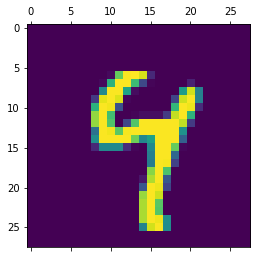

In [34]:
plt.matshow(mnist.train.images[2].reshape(28,28))
plt.show()

<h2 style="background-color:#f0b375;">
Problem 0  
<span style=font-size:50%> Complete all Problems to get the grade "1" </span>
</h2>

<p style="background-color:#adebad;">
    Shortly recapitulate the Locally Linear Embedding (LLE) algorithm, and the involved formulas.
</p>

# Locally Linear Embedding (LLE) Algorithm

1. LLE is in difference to PCA a non linear dimension reduction. 
2. It gets this non linearity by considering its nearest neighbours.
3. Cost function: $E[W] = \sum_i|X_i - \sum_j W_{ij}X_j|^2$ which is the standard lsq error commonly encoutert in encode / decode algorithms. $W_{ij}$ describes the "significance" of the $X_j$ feature point to the i'th reconstruction. 
4. W is then got by minimizing the cost function in 3. subject to the 2 constraints: 
  1. $W_{ij} = 0$ if $X_j$ is no neightbour of $X_i$ (defined by some neighboring function)
  2. $\sum_j W_{ij} = 1$ normalization constraint which also enforces translation invariance. 
5. After minimizing this cost function and optaining an optimal W we concentrate on the lower dimensional representation with a pretty similar cost function: $\phi(Y) = \sum_i | Y_i - \sum_j W_{ij} Y_j| ^2$ where we try to find an d-dimensional $Y_i$ which is a lower dimensional representation of the corresponding $X_i$ 
7. For completions sake the lsq solutions of the above terms are: 






<h2 style="background-color:#f0b375;"> Problem 1 </h2>

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
</p>

In [35]:
from sklearn.neighbors import NearestNeighbors,kneighbors_graph



class LocallyLinearEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for LLE, compare to `sklearn LLE`_.
    
    Attributes:
        embedding_vectors_ (np.ndarray): Embedding of input X with shape (samples, n_components)
        nbrs_X (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for training set X.
        nbrs_y (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for embedding_vectors_.
        M_ (np.array): Symmetric matrix (dim, dim), used in quadratic form for embedding.
        X_ (np.array): Copy of training set wioth shape (samples, dim).
    
       .. _`sklearn LLE`: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    """
    
    def __init__(self, n_neighbors=5, n_components=2):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.nbrs_X = [] # NN of each X_i
        self.nbrs_y = [] # NN of each y_i
        self.REG = 1e-3
        self.TOL = 1e-5
        self.MAX_ITER = 100
    
    def fit(self, X):
        """Compute LLE embedding of vectors X
        
        First, compute nbrs_X and M_.
        Finally, compute embedding_vectors_.
        
        Args:
            X (np.ndarray): Input array with shape (samples, dim)
        
        Returns:
            self
        """
        K = self.n_neighbors
        d_out = self.n_components
        N, d_in = X.shape
        self.X_ = X
        
        print("Fitting with neighbors: {} and components: {}".format(self.n_neighbors, self.n_components))
        
        
        ### Calculate Nearest Neighbors
        knn = NearestNeighbors(K + 1,  metric="euclidean", algorithm="ball_tree")
        knn.fit(X)
        self.nbrs_X = knn
        X_NN_INDX = knn.kneighbors(X, return_distance=False)[:,1:]
        Z = X[X_NN_INDX]
        ###
        
        ## Calculate W
        n_samples, n_neighbors = X.shape[0], Z.shape[1]
        W = np.empty((n_samples, n_neighbors))
        v = np.ones(n_neighbors)
        
        from scipy import linalg, sparse
        
        for i, A in enumerate(Z.transpose(0, 2, 1)):
            C = A.T - X[i]
            G = np.dot(C, C.T)
            trace = np.trace(G)
            R = self.REG*trace if trace > 0 else self.REG
            G.flat[::Z.shape[1] + 1] += R
            w = linalg.solve(G, v, sym_pos=True)
            W[i,:] = w / np.sum(w)
        
        
        indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
        W = sparse.csr_matrix((W.ravel(), X_NN_INDX.ravel(), indptr),shape=(n_samples, n_samples))
        
        
        ## Calulate M
        M = np.eye(W.shape[0]) - W
        M = sparse.coo_matrix(M.T * M).tocsr() 
        self.M_ = M
        
        ## Calculate Eigenvalues
        random_state = skl.utils.check_random_state(42)
        v0 = random_state.uniform(-1, 1, M.shape[0])
        v, w = sparse.linalg.eigsh(M, d_out + 1, sigma=0.0, tol=self.TOL, maxiter=self.MAX_ITER, v0=v0)
        
        self.embedding_vectors_ =  w[:, 1:]
        return self
    
    def transform(self, X):
        """Map new vectors X to embedding space
        
        Use the fitted model to map new vectors to the space with dimension n_components.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, dim)
            
        Returns:
            y (np.ndarray): Embedded vectors with shape (new_samples, n_components)
        """
        check_is_fitted(self, ["embedding_vectors_", "nbrs_X"])
        
        # identify the K nearest neighbors of x among the training inputs
        ind = self.nbrs_X.kneighbors(X, n_neighbors=self.n_neighbors, return_distance=False)
        
        ## Calculate W that reconstructs x best
        Z = self.X_[ind]
        
        n_samples, n_neighbors = X.shape[0], Z.shape[1]
        W = np.empty((n_samples, n_neighbors))
        v = np.ones(n_neighbors)
        
        from scipy import linalg, sparse
        
        for i, A in enumerate(Z.transpose(0, 2, 1)):
            C = A.T - X[i]
            G = np.dot(C, C.T)
            trace = np.trace(G)
            R = self.REG*trace if trace > 0 else self.REG
            G.flat[::Z.shape[1] + 1] += R
            w = linalg.solve(G, v, sym_pos=True)
            W[i,:] = w / np.sum(w)
        
        ## output y = sum_j w_j Y_j where the sum is over the outputs corresponding to the neighbors of x
        X_new = np.empty((X.shape[0], self.n_components))
        for i in range(X.shape[0]):
            X_new[i] = np.dot(self.embedding_vectors_[ind[i]].T, W[i])
        
        return X_new

    def inverse_transform(self, y):
        """Map new vectors y to input space with dimension dim.
        
        Use the fitted model to map vectors y to the original input space.
        
        Args:
            y (np.ndarray): Input array with shape (new_samples, n_components)
            
        Returns:
            X (np.ndarray): Vectors with shape (new_samples, dim)
        """
        # similiar to transform method
        # 1) identify the nearest neighbors of y among the training outputs 
        # 2) compute the analogous reconstruction weights
        # 3) output x = Sum_j w_j X_j
        
        
        knn = NearestNeighbors(self.n_neighbors+1,  metric="euclidean", algorithm="ball_tree")
        knn.fit(self.embedding_vectors_)
        self.nbrs_y =  knn
        
        check_is_fitted(self, ["embedding_vectors_", "X_", "nbrs_y"])
        
        ind = self.nbrs_y.kneighbors(y, n_neighbors=self.n_neighbors, return_distance=False)
        
        Z = self.embedding_vectors_[ind]
        
        n_samples, n_neighbors = y.shape[0], Z.shape[1]
        W = np.empty((n_samples, n_neighbors))
        v = np.ones(n_neighbors)
        
        from scipy import linalg, sparse
        
        for i, A in enumerate(Z.transpose(0, 2, 1)):
            C = A.T - y[i]
            G = np.dot(C, C.T)
            trace = np.trace(G)
            R = self.REG*trace if trace > 0 else self.REG
            G.flat[::Z.shape[1] + 1] += R
            w = linalg.solve(G, v, sym_pos=True)
            W[i,:] = w / np.sum(w)
        
        
        X_old = np.empty((y.shape[0], self.X_.shape[1]))
        for i in range(y.shape[0]):
            X_old[i] = np.dot(self.X_[ind[i]].T, W[i])
        
        return X_old

<p style="background-color:#adebad;">
    Create an instance of your LLE class with default parameters and fit the MNIST validation set. Record the execution time (should be about 30 sec). Furthermore, create an instance of the sklearn LLE class, and fit it with the same parameters. Again record the execution time.  
    Note, the dots should be filled in by you.
</p>

In [36]:
%%time
myLLE = LocallyLinearEmbedding()
myLLE.fit(mnist.validation.images)
myLLE

Fitting with neighbors: 5 and components: 2
CPU times: user 37.7 s, sys: 468 ms, total: 38.1 s
Wall time: 28.3 s


In [37]:
%%time
from sklearn import manifold
sklLLE = skl.manifold.LocallyLinearEmbedding(random_state=42)
sklLLE.fit(mnist.validation.images)

CPU times: user 39.5 s, sys: 400 ms, total: 39.9 s
Wall time: 34.8 s


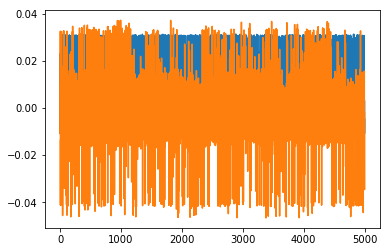

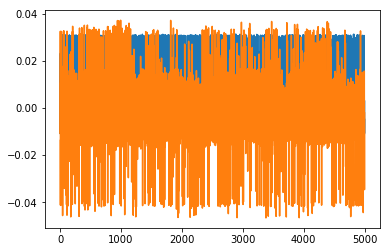

In [38]:
plt.plot(myLLE.embedding_vectors_)
plt.show()
plt.plot(sklLLE.embedding_)
plt.show()

<p style="background-color:#adebad;">
    Plot myLLE.embedding\_vectors\_ and sklLLE.embedding\_vectors\_ in two separate plots.
</p>

<h2 style="background-color:#f0b375;"> Problem 2 </h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        
        <li>Use myLLE.transform and sklLLE.transform to map the <b>MNIST test set</b> to the LLE embedding space (Maybe you have to repeat the instantiation and fitting before you can transform). sklLLE takes about 50 sec.
        </li>
        
        <li>
            Plot both embeddings in two separate plots for comparison.
        </li>
    </ul>
</p>

In [39]:
%%time
my_embedding = myLLE.transform(mnist.test.images)

CPU times: user 43 s, sys: 84 ms, total: 43 s
Wall time: 43 s


In [40]:
%%time
skl_embedding = sklLLE.transform(mnist.test.images)

CPU times: user 1min 4s, sys: 88.1 ms, total: 1min 4s
Wall time: 1min 4s


<h2 style="background-color:#f0b375;"> Problem 3 </h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>inverse_transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        <li>
        Use myLLE.transform and myLLE.inverse_transform to embed the first digit of the MNIST training set and then recover it. 
        </li>
       
    </ul>

In [41]:
embedded_digit = myLLE.transform(mnist.test.images[0].reshape(1,-1))
reconstructed_digit = myLLE.inverse_transform(embedded_digit)

<ul style="background-color:#adebad;">
        <li>
        Plot the original digit and the reconstructed digit for comparison.
        </li>
    </ul>

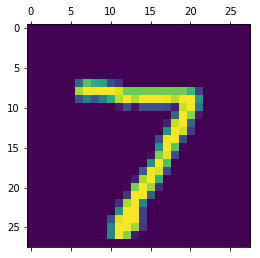

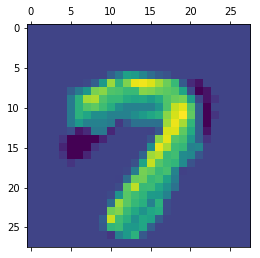

In [42]:
plt.matshow(mnist.test.images[0].reshape(28,28))
plt.show()
plt.matshow(reconstructed_digit.reshape(28,28))
plt.show()

<h2 style="background-color:#f0b375;"> Problem 4 </h2>

<ul style="background-color:#adebad;">
        <li>
        Perform more experiments (embeddings, reconstructions) with different parameters (e.g. n_neighbors, n_components).  
        Describe and plot the results. Make sure that it is clear what the reason of your experiments is, and what the outcome is.
        </li>
    </ul>

In [44]:
# 1) What im curious is how big is the error on the reconstructed digit 
# 1a) Just by the looks of the number
# 1b) By the real error 
max_neighors = 50
max_components = 10
myLLE_arr = []
for n_components in range(2, max_components, 2):    
    for n_neighbors in range(5, max_neighors, 5):
        myLLE_ = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
        myLLE_.fit(mnist.validation.images)
        myLLE_arr.append(myLLE_)




Fitting with neighbors: 5 and components: 2
Fitting with neighbors: 10 and components: 2
Fitting with neighbors: 15 and components: 2
Fitting with neighbors: 20 and components: 2
Fitting with neighbors: 25 and components: 2
Fitting with neighbors: 30 and components: 2
Fitting with neighbors: 35 and components: 2
Fitting with neighbors: 40 and components: 2
Fitting with neighbors: 45 and components: 2
Fitting with neighbors: 5 and components: 4
Fitting with neighbors: 10 and components: 4
Fitting with neighbors: 15 and components: 4
Fitting with neighbors: 20 and components: 4
Fitting with neighbors: 25 and components: 4
Fitting with neighbors: 30 and components: 4
Fitting with neighbors: 35 and components: 4
Fitting with neighbors: 40 and components: 4
Fitting with neighbors: 45 and components: 4
Fitting with neighbors: 5 and components: 6
Fitting with neighbors: 10 and components: 6
Fitting with neighbors: 15 and components: 6
Fitting with neighbors: 20 and components: 6
Fitting with 

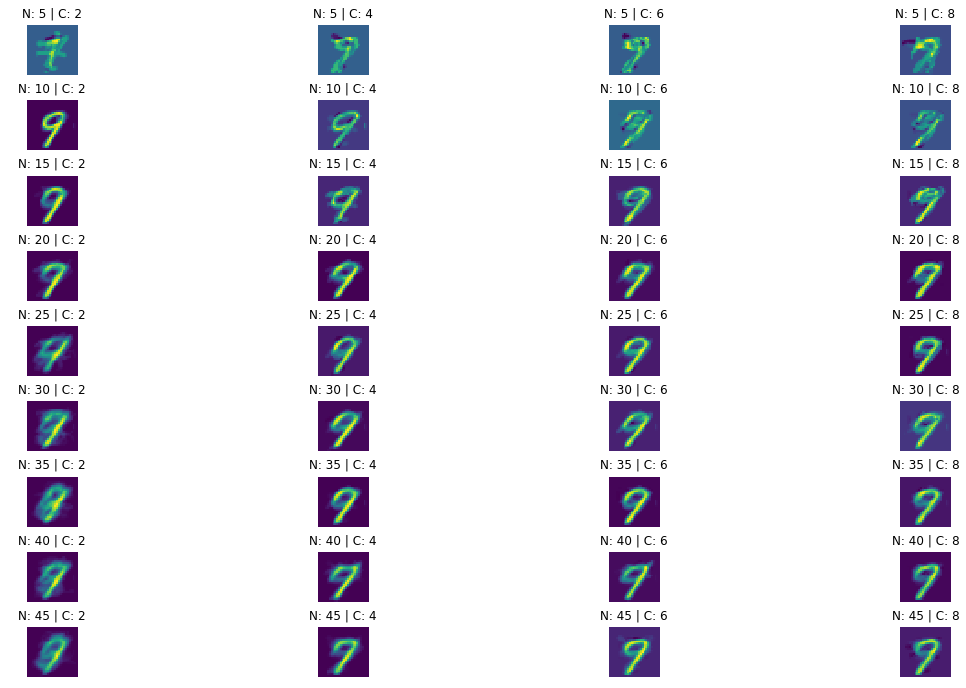

In [72]:

test_image = mnist.test.images[9]

num_neighbors = 9
num_components = 4

f,axs = plt.subplots(num_neighbors, num_components)  # create all the subplots at the start

for j in range(num_neighbors):
    for i in range(num_components):
        myLLE_ = myLLE_arr[i*num_neighbors + j]
        neighbors = myLLE_.n_neighbors
        components = myLLE_.n_components

        embedded_digit = myLLE_.transform(test_image.reshape(1,-1))
        reconstructed_digit = myLLE_.inverse_transform(embedded_digit)
        axs[j][i].matshow(reconstructed_digit.reshape(28,28))
        axs[j][i].set_title('N: {} | C: {}'.format(neighbors, components))
        axs[j][i].axis('off')

f.set_size_inches(20, 12)
f.subplots_adjust(hspace=0.5)

plt.show()


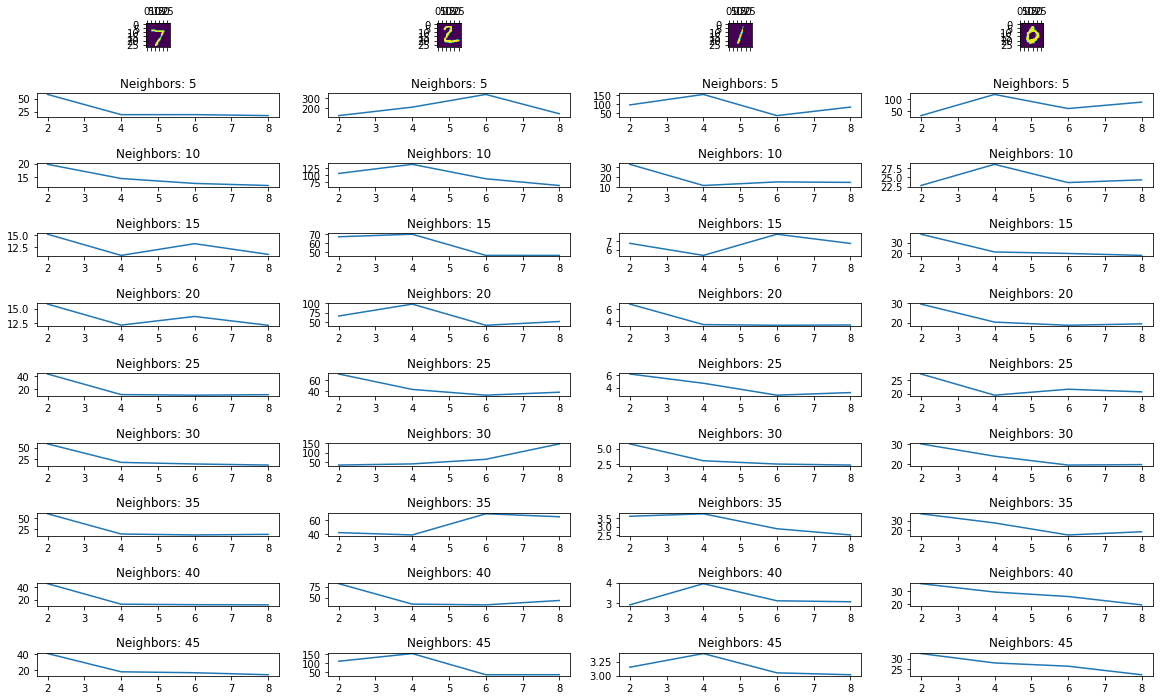

In [98]:
# Now after examine this we make the error plot 
# 2 Plots
# Plot 1: Error by number of components
# Plot 2: Error by number of neighbors

max_neighbors = 45
max_components = 8

component_array = np.linspace(2, max_components, int(max_components/2)).astype(np.int32)
neighbor_array = np.linspace(5, max_neighbors, int((max_neighbors/5))).astype(np.int32)

def mse(im1, im2):
    a = im1.T - im2.T
    return np.dot(a.T,a)

num_neighbors = 9
num_components = 4
f,axs = plt.subplots(num_neighbors+1, 4)

## try different numbers
for k in range(4):
    test_image = mnist.test.images[0+k].reshape(1, -1)
    axs[0][k].matshow(test_image.reshape(28,28))
    errors = np.zeros((num_neighbors, num_components))

    for j in range(num_neighbors):
        for i in range(num_components):
            myLLE_ = myLLE_arr[i*num_neighbors + j]
            neighbors = myLLE_.n_neighbors
            components = myLLE_.n_components

            embedded_digit = myLLE_.transform(test_image)
            reconstructed_digit = myLLE_.inverse_transform(embedded_digit)
            errors[j,i] = mse(test_image, reconstructed_digit)


    for j in range(1, num_neighbors+1):
        axs[j][k].set_title('Neighbors: {}'.format(neighbor_array[j-1]))
        axs[j][k].plot(component_array, errors[j-1,:])
    
        
f.set_size_inches(20, 12)
f.subplots_adjust(hspace=2)

#plt.show()

## Conclusion: Pretty interesting that the more neighbors we include the more components we have to use.
## every number has different preferences of neighbors/components. But a general trend which is obvs is that 
## the more neighbors / components the less the error is. 


<h2 style="background-color:#ef7575;">
Extension 1  
<span style=font-size:50%> Complete two Extensions to get the grade "2" </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the linear interpolation between two digits in the input space compared to the reconstruction along the linear interpolation of their embeddings.
        </li>
    </ul>

In [ ]:
from scipy import interpolate

grid = np.linspace(0,27, 28)

digit_8 = mnist.test.images[181].reshape(28,28)
digit_6 = mnist.test.images[161].reshape(28,28)



embedded_digit_8 = myLLE_.transform(digit_8.reshape(1,-1))
reconstructed_digit_8 = myLLE_.inverse_transform(embedded_digit_8)

embedded_digit_6 = myLLE_.transform(digit_6.reshape(1,-1))
reconstructed_digit_6 = myLLE_.inverse_transform(embedded_digit_6)

interpolate(grid, grid, )





<ul style="background-color:#adebad;">
        <li>
        Select an image of a digit "6" and a digit "8".  
        Rotate both input images by 360° in steps of 1° and create the embedding of each rotation.  
        Plot the corresponding reconstructions, and the respective path in the 2D embedding space.  
        </li>
    </ul>

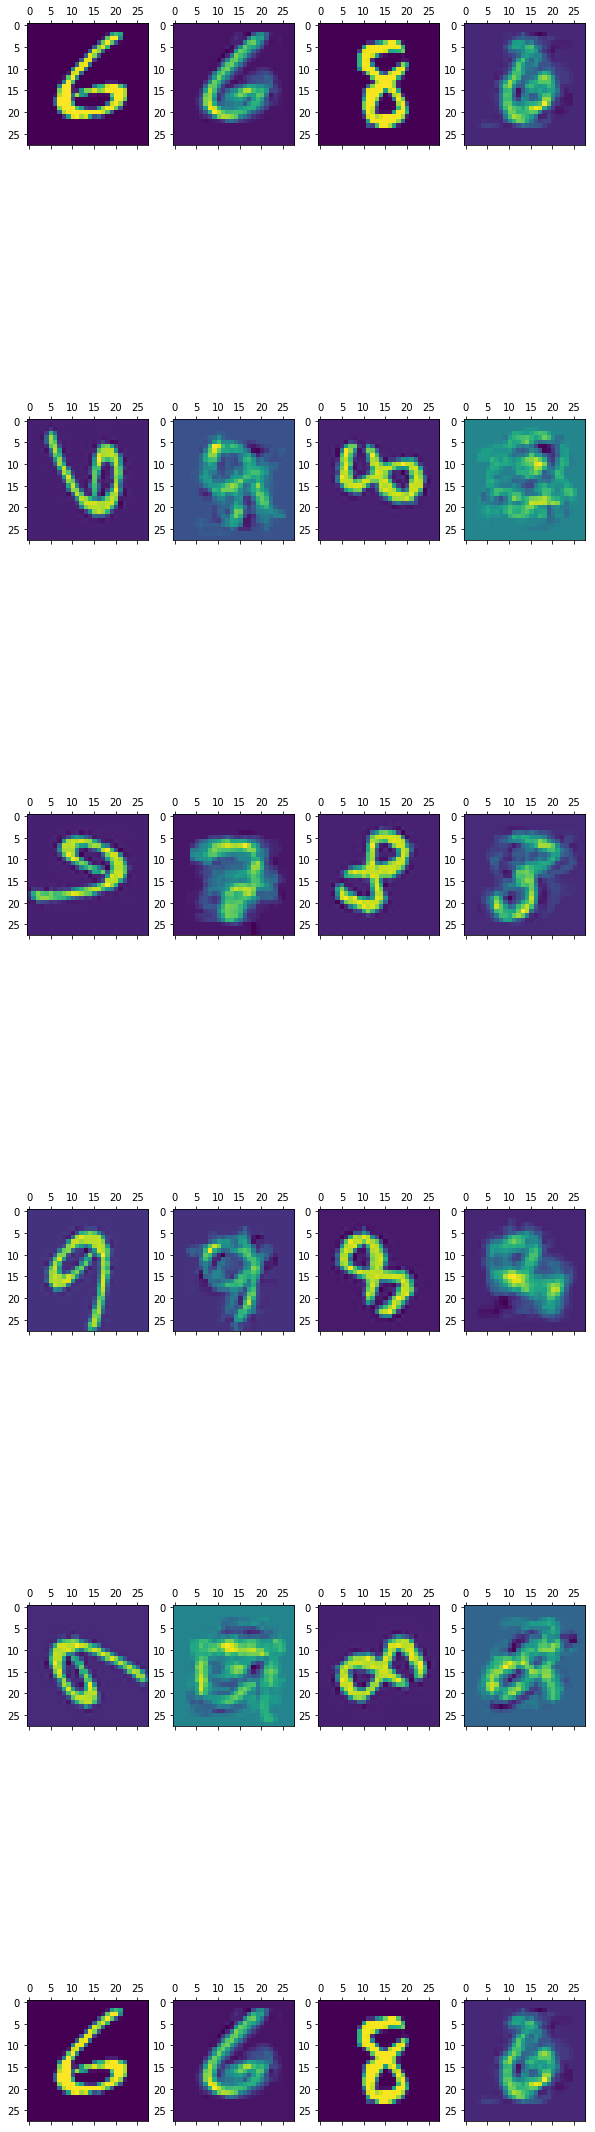

In [173]:
from scipy import ndimage

def rotate(image, angle):    
    return ndimage.rotate(image, angle, reshape=False)
    

digit_8 = mnist.test.images[181].reshape(28,28)
digit_6 = mnist.test.images[161].reshape(28,28)


rotations = np.linspace(0, 360, int(360/60)).astype(np.int32)
fig, axs = plt.subplots(len(rotations), 4)

errors = np.zeros((len(rotations), 2))

for i, each_grad in enumerate(rotations):
    rotated_img_6 = rotate(digit_6, each_grad)
    rotated_img_8 = rotate(digit_8, each_grad)
    
    
    embedded_digit_6 = myLLE_.transform(rotated_img_6.reshape(1,-1))
    reconstructed_digit_6 = myLLE_.inverse_transform(embedded_digit_6)
    
    embedded_digit_8 = myLLE_.transform(rotated_img_8.reshape(1,-1))
    reconstructed_digit_8 = myLLE_.inverse_transform(embedded_digit_8)
    
    
    errors[i,0] = mse(digit_6.reshape(1,-1), reconstructed_digit_6)
    errors[i,1] = mse(digit_8.reshape(1,-1), reconstructed_digit_8)
    
    
    axs[i,0].matshow(rotated_img_6.reshape(28,28))
    axs[i,1].matshow(reconstructed_digit_6.reshape(28,28))
    
    axs[i,2].matshow(rotated_img_8.reshape(28,28))
    axs[i,3].matshow(reconstructed_digit_8.reshape(28,28))


fig.set_size_inches(10, 40)
fig.subplots_adjust(hspace=1)
    

<h2 style="background-color:#ef7575;"> Extension 2 </h2>

<ul style="background-color:#adebad;">
        <li>
        Create a matrix plot of the matrix M\_.  
        Make sure to permute the rows and columns according to the digit labels, so that you can actually observe the block structure.
        </li>
        <li>
        Plot the spectrum (eigenvalues) of M\_. Can you identify a good cutoff? What could you use the value of the cutoff for?
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 3 </h2>

<ul style="background-color:#adebad;">
        <li>
        Train a multilayer perceptron with two hidden layers (some width between 1000-3000) on the MNIST training set (e.g. sklearn.neural_network.MLPClassifier).
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        "Embed" the MNIST validation set and the first 5000 MNIST training samples with the trained MLP.  
        To do so, use the coefs_ of the MLP to map the input digits to the first and second hidden layer.  
        In total, you should have four "embeddings": mnist_valid_1st_hidden, mnist_valid_2nd_hidden, mnist_train_1st_hidden and mnist_train_2nd_hidden.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Use LLE to embed the "embeddings" and investigate how the embedding structure changes from raw input -> first hidden layer -> second hidden layer.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Repeat the experiment, but this time with an autoencoder (e.g. sklearn.neural_network.MLPRegressor with fit(X,X)).  
        The hidden layers should be 200-500 units wide.  
        Not necessary for completion of Extension 3.
        </li>
    </ul>